In [1]:
import math
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pylab as plt
from sklearn import model_selection
from functools import reduce
from sklearn.model_selection import train_test_split

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

iter 0: Train accuracy 0.791667
iter 0: Test accuracy 0.746082
iter 0: Test Error 0.803565
iter 100: Train accuracy 0.823253
iter 100: Test accuracy 0.797806
iter 100: Test Error 0.464766
iter 200: Train accuracy 0.861559
iter 200: Test accuracy 0.833856
iter 200: Test Error 0.401314
iter 300: Train accuracy 0.875672
iter 300: Test accuracy 0.847962
iter 300: Test Error 0.372458
iter 400: Train accuracy 0.882392
iter 400: Test accuracy 0.847962
iter 400: Test Error 0.355894
iter 500: Train accuracy 0.883065
iter 500: Test accuracy 0.854232
iter 500: Test Error 0.345004
iter 600: Train accuracy 0.887097
iter 600: Test accuracy 0.860502
iter 600: Test Error 0.336895
iter 700: Train accuracy 0.889113
iter 700: Test accuracy 0.863636
iter 700: Test Error 0.331075
iter 800: Train accuracy 0.891801
iter 800: Test accuracy 0.865204
iter 800: Test Error 0.326391
iter 900: Train accuracy 0.893145
iter 900: Test accuracy 0.865204
iter 900: Test Error 0.322684
iter 1000: Train accuracy 0.893817
i

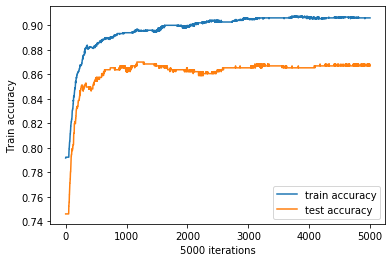

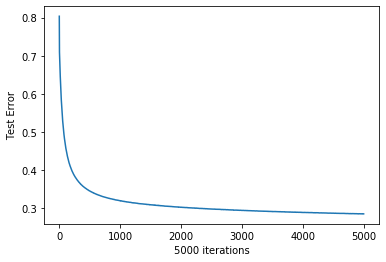

In [2]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

NUM_FEATURES = 21
NUM_CLASSES = 3

learning_rate = 0.01
epochs = 5000
beta = 1e-6
batch_size = 32
num_neurons = 10
seed = 10
np.random.seed(seed)

#read train data

train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
#split dataset in 70:30
X_train, X_test, Ytrain, Ytest = train_test_split(trainX, train_Y, test_size=0.3, random_state=20, shuffle=True)

X_train = scale(X_train, np.min(X_train, axis=0), np.max(X_train, axis=0))
X_test = scale(X_test, np.min(X_test, axis=0), np.max(X_test, axis=0))

Y_train = np.zeros((Ytrain.shape[0], NUM_CLASSES))
Y_train[np.arange(Ytrain.shape[0]), Ytrain-1] = 1 #one hot matrix

Y_test = np.zeros((Ytest.shape[0], NUM_CLASSES))
Y_test[np.arange(Ytest.shape[0]), Ytest-1] = 1 #one hot matrix


# experiment with small datasets
#trainX = trainX[:1000]
#trainY = trainY[:1000]

n = trainX.shape[0]


# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Build the graph for the deep net
	
#Build 1st layer to hidden layer
weights_to_h = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_h')
biases_to_h  = tf.Variable(tf.zeros([num_neurons]), name='biases_to_h')
hidden1 = tf.nn.relu(tf.matmul(x, weights_to_h) + biases_to_h)

#Build 2nd layer to output layer (softmax layer)
weights_to_o = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights_to_o')
biases_to_o  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_to_o')
logits  = tf.matmul(x, weights_to_o) + biases_to_o

#L2 regularization with weight decay
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
regularization = tf.nn.l2_loss(weights_to_h) + tf.nn.l2_loss(weights_to_o)
loss = tf.reduce_mean(cross_entropy + beta*regularization)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N=len(X_train)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc = []
    train_err = []
    test_acc = []
    test_err = []

    for i in range(epochs):
        np.random.shuffle(idx)
        X_train = X_train[idx]
        Y_train = Y_train[idx]
        
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: X_train[start:end], y_: Y_train[start:end]})
        
        train_acc.append(accuracy.eval(feed_dict={x: X_train, y_: Y_train}))
        test_acc.append(accuracy.eval(feed_dict={x: X_test, y_: Y_test}))
        test_err.append(loss.eval(feed_dict={x: X_test, y_:Y_test}))
          
        if i%100 == 0:
            print('iter %d: Train accuracy %g'%(i, train_acc[i]))
            print('iter %d: Test accuracy %g'%(i, test_acc[i])) 
            print('iter %d: Test Error %g'%(i, test_err[i])) 



# plot both accuracies on training and testing data against epochs
plt.figure(1)
plt.plot(range(epochs), train_acc, label = 'train accuracy')
plt.plot(range(epochs), test_acc, label= 'test accuracy')
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Train accuracy')
plt.legend()
plt.show()

# plot test error against epochs
plt.figure(2)
plt.plot(range(epochs), test_err, label= 'test error')
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Test Error')
plt.show()